# Trabajo practico final

- Materia: Procesamiento del lenguaje natural
- Alumno: Juan Andres Morales

In [1]:
#Descarga de archivos
!gdown --id 1orm_ZDfc2mbTrCutENsL4jH4yFeF9x4b -O archivos_nlp.zip

/usr/local/lib/python3.12/dist-packages/gdown/__main__.py:140: FutureWarning: Option `--id` was deprecated in version 4.3.1 and will be removed in 5.0. You don't need to pass it anymore to use a file ID.
  warnings.warn(
Downloading...
From: https://drive.google.com/uc?id=1orm_ZDfc2mbTrCutENsL4jH4yFeF9x4b
To: /content/archivos_nlp.zip
100% 3.34M/3.34M [00:00<00:00, 61.0MB/s]


In [2]:
!unzip -qn archivos_nlp.zip -d NLP_archivos # Descomprimir

### Libreria y utilidades

In [3]:
# Fix SQLite + Instalar todo
!pip install -q pysqlite3-binary

# Desinstalar conflictivos
!pip uninstall -y sentence-transformers huggingface-hub numpy -q

# Instalar versiones compatibles
!pip install -q \
    "numpy<2.0" \
    sentence-transformers==3.3.1 \
    huggingface-hub>=0.20.0 \
    langchain \
    langchain-community \
    langchain-core \
    langchain-google-genai \
    langchain-text-splitters \
    langgraph \
    chromadb \
    neo4j \
    pypdf \
    cohere \
    rank-bm25 \
    unstructured \
    markdown

print("✅ Instalación completa")

ERROR: pip's dependency resolver does not currently take into account all the packages that are installed. This behaviour is the source of the following dependency conflicts.
opencv-contrib-python 4.12.0.88 requires numpy<2.3.0,>=2; python_version >= "3.9", but you have numpy 1.26.4 which is incompatible.
shap 0.50.0 requires numpy>=2, but you have numpy 1.26.4 which is incompatible.
jaxlib 0.7.2 requires numpy>=2.0, but you have numpy 1.26.4 which is incompatible.
pytensor 2.35.1 requires numpy>=2.0, but you have numpy 1.26.4 which is incompatible.
jax 0.7.2 requires numpy>=2.0, but you have numpy 1.26.4 which is incompatible.
opencv-python 4.12.0.88 requires numpy<2.3.0,>=2; python_version >= "3.9", but you have numpy 1.26.4 which is incompatible.
opencv-python-headless 4.12.0.88 requires numpy<2.3.0,>=2; python_version >= "3.9", but you have numpy 1.26.4 which is incompatible.
✅ Instalación completa


In [4]:
import sys
import os

# --- FIX SQLITE ---
__import__('pysqlite3')
sys.modules['sqlite3'] = sys.modules.pop('pysqlite3')

# --- LIBRERÍAS DATOS ---
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from tqdm.notebook import tqdm
import json
import glob
import shutil

# --- LANGCHAIN CORE ---
from langchain_core.prompts import PromptTemplate, ChatPromptTemplate
from langchain_core.output_parsers import StrOutputParser
from langchain_core.messages import HumanMessage, AIMessage, SystemMessage
from langchain_core.runnables import RunnablePassthrough
from langchain_core.documents import Document

# --- MODELOS (GEMINI) ---
from langchain_google_genai import ChatGoogleGenerativeAI, GoogleGenerativeAIEmbeddings

# --- VECTORIAL ---
import chromadb
from langchain_community.vectorstores import Chroma
from langchain_community.embeddings import HuggingFaceEmbeddings

# --- SENTENCE TRANSFORMERS ---
from sentence_transformers import SentenceTransformer, CrossEncoder

# --- GRAFOS ---
from neo4j import GraphDatabase
from langchain_community.graphs import Neo4jGraph

# --- DOCUMENT LOADERS ---
from langchain_community.document_loaders import PyPDFLoader, TextLoader
from langchain_text_splitters import RecursiveCharacterTextSplitter

# --- VERIFICACIÓN ---
import langchain
import sentence_transformers

print(f"Python: {sys.version.split()[0]}")
print(f"NumPy: {np.__version__}")
print(f"Pandas: {pd.__version__}")
print(f"LangChain: {langchain.__version__}")
print(f"Sentence-Transformers: {sentence_transformers.__version__}")

Python: 3.12.12
NumPy: 1.26.4
Pandas: 2.2.2
LangChain: 1.1.0
Sentence-Transformers: 3.3.1


In [5]:
# Configuración del modelo de Embeddings
model_name = "intfloat/multilingual-e5-small"

encode_kwargs = {'normalize_embeddings': True} # Ayuda a mejorar la similitud del coseno

embeddings = HuggingFaceEmbeddings(
    model_name=model_name,
    model_kwargs={'device': 'cpu'},
    encode_kwargs=encode_kwargs
)

print("Modelo de embeddings cargado exitosamente.")

/tmp/ipython-input-413230721.py:6: LangChainDeprecationWarning: The class `HuggingFaceEmbeddings` was deprecated in LangChain 0.2.2 and will be removed in 1.0. An updated version of the class exists in the `langchain-huggingface package and should be used instead. To use it run `pip install -U `langchain-huggingface` and import as `from `langchain_huggingface import HuggingFaceEmbeddings``.
  embeddings = HuggingFaceEmbeddings(
/usr/local/lib/python3.12/dist-packages/huggingface_hub/utils/_auth.py:94: UserWarning: 
The secret `HF_TOKEN` does not exist in your Colab secrets.
To authenticate with the Hugging Face Hub, create a token in your settings tab (https://huggingface.co/settings/tokens), set it as secret in your Google Colab and restart your session.
You will be able to reuse this secret in all of your notebooks.
Please note that authentication is recommended but still optional to access public models or datasets.
  warnings.warn(


modules.json:   0%|          | 0.00/387 [00:00<?, ?B/s]

README.md: 0.00B [00:00, ?B/s]

sentence_bert_config.json:   0%|          | 0.00/57.0 [00:00<?, ?B/s]

config.json:   0%|          | 0.00/655 [00:00<?, ?B/s]

model.safetensors:   0%|          | 0.00/471M [00:00<?, ?B/s]

tokenizer_config.json:   0%|          | 0.00/443 [00:00<?, ?B/s]

sentencepiece.bpe.model:   0%|          | 0.00/5.07M [00:00<?, ?B/s]

tokenizer.json:   0%|          | 0.00/17.1M [00:00<?, ?B/s]

special_tokens_map.json:   0%|          | 0.00/167 [00:00<?, ?B/s]

config.json:   0%|          | 0.00/200 [00:00<?, ?B/s]

Modelo de embeddings cargado exitosamente.


### ChromaDB

Se realizo un backup de la base vectorial para no crear nuevamente la base de datos en cada iteracion del codigo. De igual manera se deja ilustrado el proceso de el procesamiento de embeddings y creacion de la BD.

In [6]:
# base_path = "/content/drive/MyDrive/NLP_archivos"
# path_manuales = os.path.join(base_path, "manuales_productos")
# path_resenas = os.path.join(base_path, "resenas_usuarios")
# path_faqs = os.path.join(base_path, "faqs.json")

# docs_procesados = []

# print("--- Procesando Manuales Markdown ---")

# # Definimos qué encabezados queremos respetar para agrupar el texto
# headers_to_split_on = [
#     ("#", "Titulo"),
#     ("##", "Seccion"),
#     ("###", "Subseccion"),
# ]

# # textsplitter
# md_splitter = MarkdownHeaderTextSplitter(headers_to_split_on=headers_to_split_on) # organiza los fragmentos según la jerarquía del documento

# # Listar archivos .md
# archivos_md = glob.glob(os.path.join(path_manuales, "*.md"))

# for archivo in tqdm(archivos_md, desc="Manuales"):
#     with open(archivo, 'r', encoding='utf-8') as f:
#         contenido = f.read()

#     # Dividir por estructura lógica (headers)
#     md_docs = md_splitter.split_text(contenido)

#     # Agregar metadata extra (nombre del archivo)
#     for doc in md_docs:
#         doc.metadata["source_type"] = "manual"
#         doc.metadata["archivo"] = os.path.basename(archivo)


#     docs_procesados.extend(md_docs)

# print(f"-> Fragmentos de manuales generados: {len(docs_procesados)}")


# # Procesamiento de reseñas
# print("\n--- Procesando Reseñas ---")

# archivos_txt = glob.glob(os.path.join(path_resenas, "*.txt"))
# docs_resenas = []

# for archivo in tqdm(archivos_txt, desc="Reseñas"):
#     try:
#         with open(archivo, 'r', encoding='utf-8') as f:
#             lines = f.readlines()

#         metadata = {"source_type": "resena", "archivo": os.path.basename(archivo)}
#         comentario = []
#         leyendo_comentario = False

#         # Parser manual
#         for line in lines:
#             line = line.strip()
#             if not line: continue # Saltar líneas vacías

#             if not leyendo_comentario:
#                 if line.startswith("Producto:"):
#                     metadata["producto"] = line.replace("Producto:", "").strip()
#                 elif line.startswith("Puntaje:"):
#                     metadata["puntaje"] = line.replace("Puntaje:", "").strip()
#                 elif line.startswith("Provincia:"):
#                     metadata["provincia"] = line.replace("Provincia:", "").strip()
#                 # Detectamos el inicio del comentario
#                 # En base a: si la línea no tiene ":" o es muy larga, es el comentario.
#                 # O por lo general el comentario empiezan después de la provincia.
#                 elif ":" not in line or len(line) > 50:
#                     leyendo_comentario = True
#                     comentario.append(line)
#             else:
#                 comentario.append(line)

#         texto_full = " ".join(comentario)

#         # Solo agregamos si hay comentario
#         if texto_full:
#             # "Opinión sobre [Producto]: [Comentario]"
#             texto_vectorizar = f"Opinión sobre {metadata.get('producto', 'producto')}: {texto_full}"

#             doc = Document(page_content=texto_vectorizar, metadata=metadata)
#             docs_resenas.append(doc)

#     except Exception as e:
#         print(f"Error en {archivo}: {e}")

# docs_procesados.extend(docs_resenas)
# print(f"-> Reseñas procesadas: {len(docs_resenas)}")


# print("\n--- Procesando FAQs ---")

# if os.path.exists(path_faqs):
#     try:
#         with open(path_faqs, 'r', encoding='utf-8') as f:
#             data_faqs = json.load(f)

#         count_faq = 0
#         for item in data_faqs:
#             # 1. Construcción del contenido semántico
#             # Es crucial incluir el nombre del producto para diferenciar garantías de distintos aparatos
#             texto_faq = (
#                 f"Producto: {item.get('nombre_producto', 'General')}\n"
#                 f"Categoría: {item.get('categoria', 'General')}\n"
#                 f"Pregunta: {item.get('pregunta', '')}\n"
#                 f"Respuesta: {item.get('respuesta', '')}"
#             )

#             # 2. Metadata
#             # Agregamos 'archivo' para mantener consistencia con los otros tipos de documentos
#             metadata = {
#                 "source_type": "faq",
#                 "id_producto": item.get("id_producto"),
#                 "id_faq": item.get("id_faq"),
#                 "utilidad": item.get("util", 0),
#                 "archivo": "faqs.json"
#             }

#             # Crear el Documento y sumarlo a la lista principal
#             doc_faq = Document(page_content=texto_faq, metadata=metadata)
#             docs_procesados.append(doc_faq)
#             count_faq += 1

#         print(f"-> FAQs procesadas: {count_faq}")

#     except Exception as e:
#         print(f"Error al procesar JSON: {e}")
# else:
#     print(f"Advertencia: No se encontró el archivo {path_faqs}")


# # Pasamos un RecursiveSplitter para asegurar
# # que ningún chunk supere el límite de contexto y estandarizar tamaños.

# final_splitter = RecursiveCharacterTextSplitter(
#     chunk_size=800,
#     chunk_overlap=100
# )

# all_splits = final_splitter.split_documents(docs_procesados)

# print(f"\nTOTAL FINAL DE CHUNKS PARA CHROMA: {len(all_splits)}")

In [7]:
# persist_directory = "./chroma_db_data"

# vectorstore = Chroma.from_documents(
#     documents=all_splits,
#     embedding=embeddings, # El modelo que definimos antes (multilingual-e5)
#     persist_directory=persist_directory,
#     collection_name="electrodomesticos_db"
# )

# print("Base de datos vectorial creada y guardada")

In [8]:
import os
import shutil
import gdown

# Dirreccion de carpeta drive
FILE_ID = "1noNBjEhizAyVdKQWyONgmEySxmElc7rK"

db_path = "./chroma_db_data"
zip_name = "backup_vectorial.zip"

print(f"--- INICIANDO CONFIGURACIÓN DE BASE VECTORIAL ---")

# 1. DESCARGA AUTOMÁTICA (Si no existe)
if not os.path.exists(db_path):
    print(f"La base no está en local. Descargando backup desde la nube...")

    # URL de descarga directa de Google Drive
    url = f'https://drive.google.com/uc?id={FILE_ID}'

    try:
        # Descargamos el ZIP
        gdown.download(url, zip_name, quiet=False)

        # Descomprimimos
        print("Descomprimiendo archivos...")
        shutil.unpack_archive(zip_name, db_path)
        print("Base de datos restaurada exitosamente.")

        # Limpieza del zip para ahorrar espacio (opcional)
        if os.path.exists(zip_name): os.remove(zip_name)

    except Exception as e:
        print(f"❌ Error crítico al descargar: {e}")
        print("Verifica que el archivo en Drive siga siendo público.")
else:
    print("La base de datos ya existe localmente. Omitiendo descarga.")


# 2. INICIALIZACIÓN DE CHROMADB
# Conectamos LangChain a la carpeta descargada
print("🔌 Conectando el motor vectorial...")

try:
    vectorstore = Chroma(
        persist_directory=db_path,
        embedding_function=embeddings, # Usa el modelo E5 que definiste arriba
        collection_name="electrodomesticos_db"
    )

    # Verificación rápida
    count = vectorstore._collection.count()
    print(f"VectorStore operativo con {count} fragmentos listos para buscar.")

except Exception as e:
    print(f"⚠️ Error conectando a Chroma: {e}")

--- INICIANDO CONFIGURACIÓN DE BASE VECTORIAL ---
La base de datos ya existe localmente. Omitiendo descarga.
🔌 Conectando el motor vectorial...


/tmp/ipython-input-2753619565.py:44: LangChainDeprecationWarning: The class `Chroma` was deprecated in LangChain 0.2.9 and will be removed in 1.0. An updated version of the class exists in the `langchain-chroma package and should be used instead. To use it run `pip install -U `langchain-chroma` and import as `from `langchain_chroma import Chroma``.
  vectorstore = Chroma(


VectorStore operativo con 9030 fragmentos listos para buscar.


In [9]:
if 'all_splits' not in globals() and 'vectorstore' in globals():
    print("Reconstruyendo documentos para el buscador híbrido")

    # Extraemos todos los datos de la colección cargada
    datos_db = vectorstore.get()

    all_splits = []
    total_docs = len(datos_db['ids'])

    for i in range(total_docs):
        # Reconstruimos el objeto Document de LangChain
        doc = Document(
            page_content=datos_db['documents'][i],
            metadata=datos_db['metadatas'][i]
        )
        all_splits.append(doc)

    print(f"✅ {len(all_splits)} documentos recuperados de la memoria para BM25.")

Reconstruyendo documentos para el buscador híbrido
✅ 9030 documentos recuperados de la memoria para BM25.


In [35]:
# Funcion para probar la base de datos vectorial
def probar_busqueda(pregunta, filtro=None, k=1):
    print(f"\n Pregunta: '{pregunta}'")
    if filtro: print(f"   (Con filtro: {filtro})")

    # Query
    query_formateada = f"query: {pregunta}"

    # Búsqueda
    results = vectorstore.similarity_search(
        query_formateada,
        k=k,
        filter=filtro # Aquí usamos la metadata que extrajimos
    )

    for i, doc in enumerate(results):
        origen = doc.metadata.get('source_type', 'desconocido')
        archivo = doc.metadata.get('archivo', 'desconocido')

        print(f"\n---Resultado {i+1} [{origen.upper()}] ---")
        print(f"Fuente: {archivo}")

        # Si es reseña, mostramos puntaje si existe
        if origen == 'resena':
            puntaje = doc.metadata.get('puntaje', 'N/A')
            print(f"-- Puntaje: {puntaje}")

        print(f" Contenido:\n{doc.page_content[:300]}...") # Muestro solo los primeros 300 caracteres
    print("\n" + "="*50)


In [11]:
# Testeo
# Prueba Técnica (Debería traer manuales o FAQs)

probar_busqueda("¿Cómo soluciono el olor de la licuadora?")

# Prueba de Opinión (Debería traer reseñas)
probar_busqueda("¿Qué opinan los usuarios sobre la potencia de la licuadora?")

# Prueba con FILTRO (Solo buscar en Manuales, ignorar opiniones)
probar_busqueda(
    "Instrucciones para picar hielo",
    filtro={"source_type": "manual"}
)


 Pregunta: '¿Cómo soluciono el olor de la licuadora?'

---Resultado 1 [FAQ] ---
Fuente: faqs.json
 Contenido:
Producto: Licuadora
Categoría: Mantenimiento
Pregunta: ¿Cómo se limpia?
Respuesta: Para limpiar el Licuadora, desconéctelo primero. Las piezas removibles pueden lavarse con agua tibia y jabón. La base debe limpiarse solo con paño húmedo. NO sumergir en agua....


 Pregunta: '¿Qué opinan los usuarios sobre la potencia de la licuadora?'

---Resultado 1 [RESENA] ---
Fuente: resena_R03546.txt
-- Puntaje: 3/5
 Contenido:
Opinión sobre Licuadora (P0002): Hola a todos! Tiene sus pros y contras con Licuadora. Tiene cosas buenas y cosas malas. Por el precio está bien, pero no esperen maravillas. Saludos!...


 Pregunta: 'Instrucciones para picar hielo'
   (Con filtro: {'source_type': 'manual'})

---Resultado 1 [MANUAL] ---
Fuente: manual_P0004_Compacto_Licuadora.md
 Contenido:
**Dificultad:** Medio | **Tiempo:** 2-3 minutos  
**Pasos:**  
1. Verificar que las cuchillas estén bien afila

### Tabular

Exploramos los datos

In [12]:
# Carga de datos tabulares
base_path = "/content/NLP_archivos"
csv_files = glob.glob(os.path.join(base_path, "*.csv"))
xlsx_files = glob.glob(os.path.join(base_path, "*.xlsx"))

df_variables = {}

# Carga CSV
for file in csv_files:
    df_name = os.path.basename(file).replace(".csv", "")
    try:
        df = pd.read_csv(file)
        df_variables[df_name] = df
        print(f"CSV Cargado: {df_name} ({df.shape})")
    except Exception as e:
        print(f"Error CSV {df_name}: {e}")

# Carga xlsx
for file in xlsx_files:
    df_name = os.path.basename(file).replace(".xlsx", "")
    if df_name in df_variables:
        # Si ya está cargado, lo ignoramos silenciosamente o avisamos
        continue
    try:
        df = pd.read_excel(file)
        df_variables[df_name] = df
        print(f"XLSX Cargado: {df_name} ({df.shape})")
    except Exception as e:
        print(f"Error XLSX {df_name}: {e}")


# Conversion de tipo de dato, para el llm
print("\n--- Normalizando Fechas y Tipos ---")

# Mapa de columnas de fecha según los archivos
mapa_fechas = {
    "ventas_historicas": ["fecha"], # tipo de estructura YYYY-MM-DD
    "tickets_soporte": ["fecha_apertura", "fecha_resolucion"],
    "devoluciones": ["fecha_devolucion", "fecha_reembolso"],
    "inventario_sucursales": ["ultima_reposicion"],
    "vendedores": ["fecha_ingreso"]
}

for nombre, cols in mapa_fechas.items():
    if nombre in df_variables:
        df = df_variables[nombre]
        for col in cols:
            if col in df.columns:
                # Convertimos a datetime. 'coerce' pone NaT si falla.
                df[col] = pd.to_datetime(df[col], errors='coerce')
                print(f"📅 {nombre}: '{col}' ahora es datetime.")

# Asegurar numéricos en productos (por si acaso)
if 'productos' in df_variables:
    df_p = df_variables['productos']
    # Si precio_usd llegara a ser objeto, lo forzamos a float
    if df_p['precio_usd'].dtype == 'object':
        df_p['precio_usd'] = pd.to_numeric(
            df_p['precio_usd'].astype(str).str.replace(r'[$,]', '', regex=True),
            errors='coerce'
        )
        print("Productos: Precio normalizado a float.")

CSV Cargado: productos ((300, 14))
CSV Cargado: ventas_historicas ((10000, 15))
CSV Cargado: vendedores ((100, 10))
CSV Cargado: tickets_soporte ((2000, 17))
CSV Cargado: devoluciones ((800, 14))
CSV Cargado: inventario_sucursales ((4100, 14))

--- Normalizando Fechas y Tipos ---
📅 ventas_historicas: 'fecha' ahora es datetime.
📅 tickets_soporte: 'fecha_apertura' ahora es datetime.
📅 tickets_soporte: 'fecha_resolucion' ahora es datetime.
📅 devoluciones: 'fecha_devolucion' ahora es datetime.
📅 devoluciones: 'fecha_reembolso' ahora es datetime.
📅 inventario_sucursales: 'ultima_reposicion' ahora es datetime.
📅 vendedores: 'fecha_ingreso' ahora es datetime.


In [13]:
# Esta función recorre dinámicamente cada DataFrame cargado en memoria y construye una representación textual detallada de su estructura.
def obtener_esquema_para_llm(dfs_dict):
    contexto = ""
    for nombre, df in dfs_dict.items():
        contexto += f"\nTabla: df_variables['{nombre}']\n"
        contexto += "Columnas:\n"
        for col in df.columns:
            dtype = df[col].dtype
            info_extra = ""

            # Rangos de fechas y números
            if pd.api.types.is_numeric_dtype(dtype):
                mn, mx = df[col].min(), df[col].max()
                info_extra = f"(Rango: {mn} a {mx})"
            elif pd.api.types.is_datetime64_any_dtype(dtype):
                mn, mx = df[col].min(), df[col].max()
                info_extra = f"(Fechas: {mn} a {mx})"
            elif dtype == 'object':
                # Valores únicos si son pocos
                unicos = df[col].dropna().unique()
                if len(unicos) < 20:
                    info_extra = f"(Opciones: {list(unicos)})"
                else:
                    info_extra = f"(Ej: {list(unicos[:2])}...)"

            contexto += f"  - {col} ({dtype}) {info_extra}\n"
        contexto += "-" * 40
    return contexto

contexto_tabular = obtener_esquema_para_llm(df_variables)

# Verificación rápida
print("\n Datos Listos. Muestra del contexto para el LLM:")
print(contexto_tabular[:1143] + "...")


 Datos Listos. Muestra del contexto para el LLM:

Tabla: df_variables['productos']
Columnas:
  - id_producto (object) (Ej: ['P0001', 'P0002']...)
  - nombre (object) (Ej: ['Licuadora', 'Plus Licuadora Pro']...)
  - categoria (object) (Opciones: ['Cocina', 'Climatización', 'Lavado', 'Audio y Video'])
  - subcategoria (object) (Opciones: ['Preparación', 'Cocción', 'Refrigeración', 'Pequeños Electrodomésticos', 'Aires Acondicionados', 'Calefacción', 'Ventilación', 'Purificación', 'Lavado de Ropa', 'Secado', 'Lavado de Vajilla', 'Planchado', 'Televisores'])
  - marca (object) (Opciones: ['TechHome', 'ChefMaster', 'HomeChef', 'KitchenPro', 'CookElite', 'PureAir', 'EcoClima', 'ClimaTech', 'ThermoControl', 'AirFlow', 'WashPro', 'SparkleHome', 'CleanMaster', 'LaundryTech', 'FreshWash', 'VisionPro', 'ScreenPro'])
  - precio_usd (float64) (Rango: 28.22 a 2992.33)
  - stock (int64) (Rango: 1 a 200)
  - color (object) (Opciones: ['Blanco', 'Rosa', 'Negro', 'Azul', 'Dorado', 'Gris', 'Plateado', 'V

### Carga del modelo LLM

In [14]:
from google.colab import userdata
GOOGLE_API_KEY = userdata.get("GOOGLE_API_KEY") # API key secreta

In [15]:
llm_gemini = ChatGoogleGenerativeAI(
    model="gemini-2.0-flash",
    temperature=0, # Temperatura 0 para máxima precisión en código
    google_api_key=GOOGLE_API_KEY
)

# Prompt
template_pandas = """
Actúa como un experto data scientist. Tienes los siguientes dataframes cargados en un diccionario `df_variables`:
{contexto}

TU TAREA:
Escribe código Python Pandas para responder a la pregunta: "{consulta}"

REGLAS OBLIGATORIAS:
1. El código debe ser ejecutable sin errores.
2. DEBES guardar la respuesta final en una variable llamada `resultado`.
3. Usa `df_variables['nombre_tabla']` para acceder a los datos.
4. Para filtrar fechas, usa propiedades .dt (ej: .dt.year == 2024).
5. NO inventes columnas.
6. IMPORTANTE: Solo devuelve el código Python puro. NO uses bloques markdown (```python), ni explicaciones.

Código:
"""

prompt_pandas = PromptTemplate(
    template=template_pandas,
    input_variables=["contexto", "consulta"]
)

# Chain
chain_pandas = prompt_pandas | llm_gemini | StrOutputParser()

# Consulta a la tabla
def table_search(consulta):
    print(f"📊 Consultando Tablas: '{consulta}'")

    try:
        # Invocar al LLM
        codigo = chain_pandas.invoke({
            "contexto": contexto_tabular, # Usamos el contexto que generamos antes
            "consulta": consulta
        })

        # Limpieza de string (Gemini a veces agrega ```python)
        codigo = codigo.replace("```python", "").replace("```", "").strip()
        print(f"💻 Código Generado:\n{codigo}\n")

        # Ejecución Segura
        local_scope = {"df_variables": df_variables, "pd": pd}

        exec(codigo, globals(), local_scope)

        # Obtener resultado
        if "resultado" in local_scope:
            return str(local_scope["resultado"])
        else:
            return "Error: El código se ejecutó pero no generó la variable 'resultado'."

    except Exception as e:
        return f"Error de ejecución: {e}"

print("Función table_search creada con Gemini.")

Función table_search creada con Gemini.


In [16]:
# Test
print(table_search("¿Cuál es el producto mas caro de 2024?"))

📊 Consultando Tablas: '¿Cuál es el producto mas caro de 2024?'
💻 Código Generado:
import pandas as pd

ventas_2024 = df_variables['ventas_historicas'][df_variables['ventas_historicas']['fecha'].dt.year == 2024]

producto_mas_caro = ventas_2024.loc[ventas_2024['precio_unitario'].idxmax()]

resultado = producto_mas_caro['nombre_producto']

Advanced Heladera


### Neo4j

In [17]:
# Preparacion de los datos
# 'productos.csv' para crear nodos y relaciones.
# Nodos: Producto, Categoria, Marca
# Relaciones: PERTENECE_A, FABRICADO_POR

if 'productos' in df_variables:

    df_prod = df_variables['productos']
    df_graph = df_prod[['id_producto', 'nombre', 'categoria', 'marca', 'precio_usd']].copy()

    # Limpieza
    df_graph['nombre'] = df_graph['nombre'].astype(str).str.replace("'", "").str.replace('"', '')
    df_graph['categoria'] = df_graph['categoria'].astype(str).str.replace("'", "")
    df_graph['marca'] = df_graph['marca'].astype(str).str.replace("'", "")

    print(f"Datos preparados para Grafos: {len(df_graph)} productos listos.")
    display(df_graph.head(3))
else:
    print("Error: No se encontró el dataframe 'productos'. Revisa la carga tabular.")

Datos preparados para Grafos: 300 productos listos.


,id_producto,nombre,categoria,marca,precio_usd
0,P0001,Licuadora,Cocina,TechHome,283.63
1,P0002,Licuadora,Cocina,TechHome,1273.06
2,P0003,Plus Licuadora Pro,Cocina,TechHome,329.07


In [18]:
# Data
URI = "neo4j+s://1c8a8ed6.databases.neo4j.io"
neo4j_pass = userdata.get("neo4j_pass")
AUTH = ("neo4j", neo4j_pass)

# Función para limpiar la base
def limpiar_base(tx):
    tx.run("MATCH (n) DETACH DELETE n")

# Función para crear nodos y relaciones
def crear_grafo(tx, row):
    # Query Cypher: Crea Producto, Categoria, Marca y los une
    query = """
    MERGE (p:Producto {id: $id, nombre: $nombre, precio: $precio})
    MERGE (c:Categoria {nombre: $categoria})
    MERGE (m:Marca {nombre: $marca})

    MERGE (p)-[:PERTENECE_A]->(c)
    MERGE (p)-[:FABRICADO_POR]->(m)
    """
    tx.run(query,
           id=row['id_producto'],
           nombre=row['nombre'],
           precio=row['precio_usd'],
           categoria=row['categoria'],
           marca=row['marca'])

# Ejecucion
try:
    with GraphDatabase.driver(URI, auth=AUTH) as driver:
        driver.verify_connectivity()
        print("Conexión exitosa a Neo4j AuraDB.")

        with driver.session() as session:
            # Limpiar
            print("Limpiando base antigua...")
            session.execute_write(limpiar_base)

            # Cargar datos iterando el DataFrame
            print(f"Cargando {len(df_graph)} productos...")
            for index, row in df_graph.iterrows():
                session.execute_write(crear_grafo, row)

        print("Carga completa. El grafo está listo.")

except Exception as e:
    print(f"Error de conexión o carga: {e}")

Conexión exitosa a Neo4j AuraDB.
Limpiando base antigua...
Cargando 300 productos...
Carga completa. El grafo está listo.


In [19]:
# Le pasamos como es la estructura
schema_grafo = """
Nodos:
  - (:Producto {nombre: STRING, precio: FLOAT, id: STRING})
  - (:Categoria {nombre: STRING})
  - (:Marca {nombre: STRING})

Relaciones:
  - (:Producto)-[:PERTENECE_A]->(:Categoria)
  - (:Producto)-[:FABRICADO_POR]->(:Marca)
"""

# Prompt para generar cypher
template_cypher = """
Eres un experto en Neo4j y Cypher. Tienes el siguiente esquema de base de datos de grafos:
{schema}

TU TAREA:
Escribe una consulta CYPHER para responder a la pregunta: "{consulta}"

REGLAS:
1. Usa MATCH para buscar patrones.
2. Usa WHERE con 'CONTAINS' (case-insensitive si es posible) para buscar nombres de productos o categorías, ya que el usuario puede no escribir el nombre exacto.
   Ejemplo: WHERE toLower(p.nombre) CONTAINS toLower('licuadora')
3. Retorna siempre información útil (ej: nombre del producto, precio, categoría).
4. NO uses markdown (```cypher). Solo el código.
5. Limita los resultados a 10 si no se especifica cantidad.

Consulta Cypher:
"""

prompt_cypher = PromptTemplate(
    template=template_cypher,
    input_variables=["schema", "consulta"]
)

chain_cypher = prompt_cypher | llm_gemini | StrOutputParser() # StrOutputParser era para poder pasarle la salida como texto despues en la funcion

# Funcion de busqueda en grafo
def graph_search(consulta):
    print(f"Consultando Grafo: '{consulta}'")

    try:
        # Generar Query
        cypher_query = chain_cypher.invoke({
            "schema": schema_grafo,
            "consulta": consulta
        })

        # Limpieza básica
        cypher_query = cypher_query.replace("```cypher", "").replace("```", "").strip()
        print(f"Query Cypher:\n{cypher_query}")

        # Ejecutar en Neo4j
        # Usamos el driver que ya configuraste en el paso anterior
        with GraphDatabase.driver(URI, auth=AUTH) as driver:
            records, summary, keys = driver.execute_query(cypher_query)

            # Formatear resultados
            # Neo4j devuelve objetos, los convertimos a texto legible
            resultados_txt = []
            if not records:
                return "No se encontraron relaciones en el grafo para esa consulta."

            for record in records:
                # Convertimos cada registro a string (ej: clave: valor)
                resultados_txt.append(str(record.data()))

            return "\n".join(resultados_txt)

    except Exception as e:
        return f"Error consultando el grafo: {e}"


print("Función graph_search creada.")

Función graph_search creada.


In [20]:
# Prueba 1: Buscar por Categoría (Relación PERTENECE_A)
print(graph_search("¿Qué productos hay en la categoría Cocina?"))

print("\n" + "="*50 + "\n")

# Prueba 2: Buscar por Marca (Relación FABRICADO_POR) y precio
print(graph_search("Dime productos de la marca ChefMaster que cuesten menos de 150 dólares"))

Consultando Grafo: '¿Qué productos hay en la categoría Cocina?'
Query Cypher:
MATCH (p:Producto)-[:PERTENECE_A]->(c:Categoria)
WHERE toLower(c.nombre) CONTAINS toLower('Cocina')
RETURN p.nombre AS Producto, p.precio AS Precio, c.nombre AS Categoria
LIMIT 10
{'Producto': 'Olla de Cocción Lenta Plus', 'Precio': 1173.57, 'Categoria': 'Cocina'}
{'Producto': 'Plus Olla de Cocción Lenta', 'Precio': 321.63, 'Categoria': 'Cocina'}
{'Producto': 'Olla de Cocción Lenta X', 'Precio': 1958.25, 'Categoria': 'Cocina'}
{'Producto': 'Advanced Heladera', 'Precio': 2992.33, 'Categoria': 'Cocina'}
{'Producto': 'Compacto Heladera', 'Precio': 161.81, 'Categoria': 'Cocina'}
{'Producto': 'Heladera', 'Precio': 530.69, 'Categoria': 'Cocina'}
{'Producto': 'Elite Heladera', 'Precio': 784.59, 'Categoria': 'Cocina'}
{'Producto': 'Plus Heladera', 'Precio': 1384.08, 'Categoria': 'Cocina'}
{'Producto': 'Premium Heladera', 'Precio': 841.57, 'Categoria': 'Cocina'}
{'Producto': 'Advanced Freezer', 'Precio': 770.6, 'Categ

### Clasificador de Intención Avanzado

Clasificador propio

In [21]:
from sklearn.model_selection import train_test_split

# Preguntas sintéticas para cada categoría
# VECTORIAL: Manuales, garantías, opiniones, usos.
data_vectorial = [
    ("¿Cómo limpio la licuadora?", "vectorial"),
    ("¿Qué cubre la garantía del horno?", "vectorial"),
    ("Opiniones sobre la cafetera express", "vectorial"),
    ("¿Por qué mi batidora hace ruido?", "vectorial"),
    ("Instrucciones para picar hielo", "vectorial"),
    ("¿Qué dicen los usuarios del modelo P004?", "vectorial"),
    ("Manual de uso del secador", "vectorial"),
    ("Pasos para instalar el lavarropas", "vectorial"),
    ("¿Es normal que caliente tanto?", "vectorial"),
    ("Reseñas negativas de la plancha", "vectorial"),
    ("¿Cómo se usa el timer?", "vectorial"),
    ("Recetas para la licuadora", "vectorial"),
    ("El equipo no enciende", "vectorial"),
    ("Ruido extraño en el motor", "vectorial"),
    ("¿Qué voltaje lleva?", "vectorial")
]

# TABULAR: Precios, stock, ventas, fechas, cantidades.
data_tabular = [
    ("¿Cuál fue el total de ventas en 2024?", "tabular"),
    ("Precio de la licuadora P002", "tabular"),
    ("¿Cuántas unidades quedan en stock?", "tabular"),
    ("Ventas totales del vendedor Juan", "tabular"),
    ("Promedio de facturación mensual", "tabular"),
    ("Listar productos con precio mayor a 100", "tabular"),
    ("¿Cuál fue la venta más alta de mayo?", "tabular"),
    ("Cantidad de devoluciones la semana pasada", "tabular"),
    ("Stock disponible en sucursal Centro", "tabular"),
    ("¿Cuánto vendió María Gomez?", "tabular"),
    ("Total recaudado en efectivo", "tabular"),
    ("Ventas del día 15/05/2024", "tabular"),
    ("¿Cuál es el producto más barato?", "tabular"),
    ("¿Cuántos tickets de soporte hay abiertos?", "tabular"),
    ("Fecha de ingreso del vendedor Pedro", "tabular")
]

# GRAFOS: Relaciones, categorías, marcas, jerarquías.
data_grafos = [
    ("¿Qué productos pertenecen a la categoría Cocina?", "grafos"),
    ("Listar productos de la marca ChefMaster", "grafos"),
    ("¿Qué accesorios son compatibles con la batidora?", "grafos"),
    ("¿Qué productos están relacionados con Limpieza?", "grafos"),
    ("Mostrar la jerarquía de productos", "grafos"),
    ("Dime todos los electrodomésticos de la marca Sony", "grafos"),
    ("¿Qué productos comparten la misma categoría que la licuadora?", "grafos"),
    ("Explorar relaciones del producto P001", "grafos"),
    ("Marcas que fabrican cafeteras", "grafos"),
    ("¿A qué categoría pertenece el mixer?", "grafos"),
    ("¿Quién fabrica el modelo P005?", "grafos"),
    ("Productos relacionados con Aire Acondicionado", "grafos"),
    ("Dime la categoría de la plancha", "grafos"),
    ("¿Qué marca produce el televisor 4K?", "grafos"),
    ("Conexiones del producto Lavarropas", "grafos")
]

# Unimos y creamos DataFrame
all_data = data_vectorial + data_tabular + data_grafos
df_dataset = pd.DataFrame(all_data, columns=["texto", "intencion"])

# 3. División Train/Test (70% entrenamiento, 30% evaluación)
X_train, X_test, y_train, y_test = train_test_split(
    df_dataset["texto"],
    df_dataset["intencion"],
    test_size=0.3,
    random_state=42,
    stratify=df_dataset["intencion"] # Asegura balance de clases
)

print(f"Dataset creado. Train: {len(X_train)}, Test: {len(X_test)}")

Dataset creado. Train: 31, Test: 14


In [22]:
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.svm import SVC
from sklearn.pipeline import Pipeline
from sklearn.metrics import classification_report

print("--- ENTRENANDO CLASIFICADOR SVM ---")

# Pipeline: Vectorizador TF-IDF -> SVM (Support Vector Machine)
pipeline_ml = Pipeline([
    ('tfidf', TfidfVectorizer(ngram_range=(1,2))), # Usa palabras sueltas y bigramas
    ('clf', SVC(kernel='linear', probability=True))
])

# Entrenar
pipeline_ml.fit(X_train, y_train)

# Evaluar
y_pred_ml = pipeline_ml.predict(X_test)

print("Reporte de Clasificación (Modelo Propio SVM):")
print(classification_report(y_test, y_pred_ml))

--- ENTRENANDO CLASIFICADOR SVM ---
Reporte de Clasificación (Modelo Propio SVM):
              precision    recall  f1-score   support

      grafos       0.33      0.75      0.46         4
     tabular       1.00      0.40      0.57         5
   vectorial       0.67      0.40      0.50         5

    accuracy                           0.50        14
   macro avg       0.67      0.52      0.51        14
weighted avg       0.69      0.50      0.51        14



La baja performance se debe principalmente a la escasez de datos de entrenamiento (Small Data). Los modelos estadísticos supervisados como SVM requieren una cantidad grande de ejemplos variados para trazar hiperplanos de separación efectivos en un espacio vectorial de alta dimensionalidad. Con un set de datos sintético pequeño, el modelo no logra generalizar el vocabulario necesario.

In [23]:
# Prompt Few-Shot
prompt_clasificador = """
Eres un clasificador de intenciones. Clasifica la consulta en una de estas 3 categorías:

1. "vectorial": Manuales, uso, opiniones, garantías, solución de problemas, reseñas.
2. "tabular": Cálculos, precios exactos, stock, ventas, fechas, estadísticas, inventario, devoluciones.
3. "grafos": Relaciones, marcas, categorías, compatibilidad, jerarquías, productos.

EJEMPLOS:
- "Cómo uso la licuadora" -> vectorial
- "Total ventas ayer" -> tabular
- "Qué marca fabrica esto" -> grafos

CONSULTA: "{consulta}"

Responde SOLO con una palabra (vectorial, tabular, grafos).
"""

template_clasif = PromptTemplate(template=prompt_clasificador, input_variables=["consulta"])
chain_clasif = template_clasif | llm_gemini | StrOutputParser()

def clasificar_con_llm(consultas):
    preds = []
    # Usamos tqdm para ver el progreso porque el LLM tarda un poco
    for q in tqdm(consultas, desc="Clasificando con Gemini"):
        try:
            resp = chain_clasif.invoke({"consulta": q})
            clase = resp.lower().strip().replace(".", "").replace('"', '')

            # Limpieza básica
            if "vectorial" in clase: preds.append("vectorial")
            elif "tabular" in clase: preds.append("tabular")
            elif "grafos" in clase: preds.append("grafos")
            else: preds.append("desconocido")
        except:
            preds.append("error")
    return preds

# Convertimos X_test a lista
lista_test = X_test.tolist()

# Predecir con LLM
y_pred_llm = clasificar_con_llm(lista_test)

print("\nReporte de Clasificación (LLM Gemini):")
print(classification_report(y_test, y_pred_llm))

Clasificando con Gemini:   0%|          | 0/14 [00:00<?, ?it/s]

* Quota exceeded for metric: generativelanguage.googleapis.com/generate_content_free_tier_requests, limit: 15, model: gemini-2.0-flash
Please retry in 18.645064114s. [links {
  description: "Learn more about Gemini API quotas"
  url: "https://ai.google.dev/gemini-api/docs/rate-limits"
}
, violations {
  quota_metric: "generativelanguage.googleapis.com/generate_content_free_tier_requests"
  quota_id: "GenerateRequestsPerMinutePerProjectPerModel-FreeTier"
  quota_dimensions {
    key: "model"
    value: "gemini-2.0-flash"
  }
  quota_dimensions {
    key: "location"
    value: "global"
  }
  quota_value: 15
}
, retry_delay {
  seconds: 18
}
].
* Quota exceeded for metric: generativelanguage.googleapis.com/generate_content_free_tier_requests, limit: 15, model: gemini-2.0-flash
Please retry in 16.590522045s. [links {
  description: "Learn more about Gemini API quotas"
  url: "https://ai.google.dev/gemini-api/docs/rate-limits"
}
, violations {
  quota_metric: "generativelanguage.googleapis.


Reporte de Clasificación (LLM Gemini):
              precision    recall  f1-score   support

      grafos       1.00      1.00      1.00         4
     tabular       1.00      1.00      1.00         5
   vectorial       1.00      1.00      1.00         5

    accuracy                           1.00        14
   macro avg       1.00      1.00      1.00        14
weighted avg       1.00      1.00      1.00        14



El clasificador basado en LLM es la opción seleccionada para el Agente. Puede llegar a presenta una latencia de inferencia ligeramente mayor que un modelo tradicional, la precision en la detección de la intención justifica su uso, garantizando que el usuario siempre sea dirigido a la herramienta correcta (Base de Datos, Manuales o Grafos) desde el primer intento.

PIPELINE DE RECUPERACION

In [24]:
!pip install -qU langchain rank_bm25 sentence-transformers

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 102.1/102.1 kB 3.1 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 488.0/488.0 kB 12.6 MB/s eta 0:00:00


In [25]:
import numpy as np
from sentence_transformers import CrossEncoder
from langchain_community.retrievers import BM25Retriever

# PREPARAR RETRIEVERS
# BM25 (Palabras Clave)
if 'all_splits' in globals():
    bm25_retriever = BM25Retriever.from_documents(all_splits)
    bm25_retriever.k = 5
else:
    print("⚠️ Error: 'all_splits' no definido. Ejecuta la carga vectorial primero.")

# MODELO DE RERANKING (CrossEncoder)
# Este modelo compara pares (Pregunta, Documento) y dice qué tan buenos son.
try:
    reranker_model = CrossEncoder('BAAI/bge-reranker-v2-m3')
except Exception as e:
    print(f"⚠️ Error cargando CrossEncoder (asegúrate de haber hecho pip install sentence-transformers): {e}")

# --- FUNCIÓN DE BÚSQUEDA ---

def doc_search(consulta, top_k=3):
    print(f"\n🔎 CONSULTA: '{consulta}'")

    try:
        # Recuperación BM25 (Palabras Clave)
        docs_bm25 = bm25_retriever.invoke(consulta)
        print(f"   [BM25] Encontró {len(docs_bm25)} candidatos.")

        # Recuperación Chroma (Semántica)
        # IMPORTANTE: E5 requiere el prefijo 'query: ' para funcionar bien
        docs_chroma = vectorstore.similarity_search(f"query: {consulta}", k=5)
        print(f"   [Chroma] Encontró {len(docs_chroma)} candidatos.")

        # Fusión y Deduplicación
        candidatos_dict = {}

        # Primero agregamos BM25
        for doc in docs_bm25:
            candidatos_dict[doc.page_content] = doc

        # Luego Chroma (si ya existe, no lo duplica)
        for doc in docs_chroma:
            candidatos_dict[doc.page_content] = doc

        candidatos = list(candidatos_dict.values())

        if not candidatos:
            return "❌ No se encontraron documentos candidatos en ninguna fuente."

        print(f"-> Total candidatos únicos: {len(candidatos)}. Re-rankeando...")

        # Re-Ranking
        pares = [[consulta, doc.page_content] for doc in candidatos]
        scores = reranker_model.predict(pares)

        # Ordenar
        indices_ordenados = np.argsort(scores)[::-1]

        resultados_finales = []

        for i in range(min(top_k, len(candidatos))):
            idx = indices_ordenados[i]
            doc = candidatos[idx]
            score = scores[idx]
            print(f"-> Candidato {i+1}: Score {score:.4f} ({doc.metadata.get('source_type')})")

            # Umbral
            if score > -10:
                fuente = doc.metadata.get('archivo', 'Desconocido')
                tipo = doc.metadata.get('source_type', 'texto')

                texto_fmt = f"[Fuente: {fuente} ({tipo}) | Relevancia: {score:.2f}]\n{doc.page_content}"
                resultados_finales.append(texto_fmt)

        if not resultados_finales:
            return "Información encontrada pero descartada por baja relevancia."

        return "\n\n".join(resultados_finales)

    except Exception as e:
        return f"Error crítico en doc_search: {e}"


config.json:   0%|          | 0.00/795 [00:00<?, ?B/s]

model.safetensors:   0%|          | 0.00/2.27G [00:00<?, ?B/s]

tokenizer_config.json: 0.00B [00:00, ?B/s]

sentencepiece.bpe.model:   0%|          | 0.00/5.07M [00:00<?, ?B/s]

tokenizer.json:   0%|          | 0.00/17.1M [00:00<?, ?B/s]

special_tokens_map.json:   0%|          | 0.00/964 [00:00<?, ?B/s]

In [26]:
# --- GENERACIÓN DE RESPUESTA FINAL (RAG) ---

template_generacion = """
Eres el asistente virtual de ElectroHogar.
Tu misión es responder al usuario usando la INFORMACIÓN RECUPERADA que te provee el sistema.

PREGUNTA DEL USUARIO: "{pregunta}"

INFORMACIÓN RECUPERADA (Contexto):
{contexto}

INSTRUCCIONES:
1. Usa SOLO la información recuperada para responder.
2. Si la información contiene datos numéricos o tablas, explícalos en lenguaje natural.
3. Si la información no es suficiente, di amablemente que no tienes datos sobre eso.
4. Responde en el mismo idioma que la pregunta.

Respuesta:
"""

prompt_gen = PromptTemplate(template=template_generacion, input_variables=["pregunta", "contexto"])
chain_gen = prompt_gen | llm_gemini | StrOutputParser()

def generar_respuesta(pregunta, contexto):
    return chain_gen.invoke({"pregunta": pregunta, "contexto": contexto})

In [27]:
# Cerebro del sistema rag
# integra el Clasificador (chain_clasif), los Recuperadores (if intencion == ...: doc_search/table_search) y el Generador (generar_respuesta)
def sistema_rag_v1(pregunta, historial_chat=""):
    print(f"\n💬 Usuario: {pregunta}")

    # CLASIFICACIÓN DE INTENCIÓN
    try:
        clasificacion_resp = chain_clasif.invoke({"consulta": pregunta})
        intencion = clasificacion_resp.lower().strip().replace(".", "")
        # Normalización simple
        if "vectorial" in intencion: intencion = "vectorial"
        elif "tabular" in intencion: intencion = "tabular"
        elif "grafos" in intencion: intencion = "grafos"
    except:
        intencion = "vectorial" # Fallback por defecto

    print(f"🧠 Intención detectada: {intencion.upper()}")

    # RECUPERACIÓN (Retrieval)
    contexto = ""

    if intencion == "vectorial":
        # Usamos el pipeline híbrido
        contexto = doc_search(pregunta)

    elif intencion == "tabular":
        # Usamos el buscador de pandas
        contexto = table_search(pregunta)

    elif intencion == "grafos":
        # Usamos el buscador de Neo4j
        contexto = graph_search(pregunta)

    print(f"📄 Contexto recuperado (Raw): {str(contexto)[:100]}...") # Mostramos un poco para debug


    respuesta_final = generar_respuesta(pregunta, contexto)

    return respuesta_final

In [28]:
# Bucle final

print("=== ASISTENTE ELECTROHOGAR (Versión RAG Clásico) ===")
print("Escribe 'salir' para terminar.\n")

historial = []

while True:
    consulta = input("\nTu pregunta: ")

    if consulta.lower() in ['salir', 'chau', 'exit']:
        print("¡Hasta luego!")
        break

    # Ejecutamos el sistema
    respuesta = sistema_rag_v1(consulta)

    print(f"🤖 Asistente: {respuesta}")

    # Guardamos en historial (opcional para cumplir el requisito de memoria básico)
    historial.append((consulta, respuesta))

=== ASISTENTE ELECTROHOGAR (Versión RAG Clásico) ===
Escribe 'salir' para terminar.


Tu pregunta: ¿Cómo limpio la licuadora?

💬 Usuario: ¿Cómo limpio la licuadora?
🧠 Intención detectada: VECTORIAL

🔎 CONSULTA: '¿Cómo limpio la licuadora?'
   [BM25] Encontró 5 candidatos.
   [Chroma] Encontró 5 candidatos.
-> Total candidatos únicos: 9. Re-rankeando...
-> Candidato 1: Score 0.9994 (faq)
-> Candidato 2: Score 0.9976 (faq)
-> Candidato 3: Score 0.9955 (faq)
📄 Contexto recuperado (Raw): [Fuente: faqs.json (faq) | Relevancia: 1.00]
Producto: Licuadora
Categoría: Mantenimiento
Pregunta: ...
🤖 Asistente: Para limpiar la licuadora, primero desconéctala. Las piezas removibles se pueden lavar con agua tibia y jabón. La base debe limpiarse solo con un paño húmedo y no debe sumergirse en agua.

Tu pregunta: ¿Cuál fue el total del ultimo dia de ventas?

💬 Usuario: ¿Cuál fue el total del ultimo dia de ventas?
🧠 Intención detectada: TABULAR
📊 Consultando Tablas: '¿Cuál fue el total del ultimo dia de

## Parte 2 (Agente)

Creamos un conjunto de herramientas para que el agente utilice

In [29]:
from langchain_core.tools import tool

# Se definen herramientas a utilizar
# Se encapsulan las funciones de búsqueda y análisis con el decorador @tool de LangChain para dotarlas de descripciones semánticas que el LLM pueda entender.

@tool
def tool_vectorial(consulta: str):
    """
    Útil para buscar información CUALITATIVA: manuales de uso, instrucciones,
    garantías, solución de problemas técnicos (ruidos, fallas) y opiniones/reseñas de usuarios.
    Usa esto cuando pregunten 'cómo', 'por qué', 'qué opinan' o problemas técnicos.
    """
    return doc_search(consulta)

@tool
def tool_tabular(consulta: str):
    """
    Útil para consultar información CUANTITATIVA y exacta: ventas, precios, stock,
    inventario, fechas, vendedores y montos.
    Usa esto cuando pregunten 'cuánto', 'precio', 'stock', 'total'.
    """
    return table_search(consulta)

@tool
def tool_grafos(consulta: str):
    """
    Útil para consultar RELACIONES: categorías, marcas, jerarquías y compatibilidad.
    Usa esto cuando pregunten 'qué productos son de la categoría X', 'quién fabrica Y',
    o 'qué accesorios sirven para Z'.
    """
    return graph_search(consulta)

# HERRAMIENTA PARA GENERAR LOS GRAFICOS

@tool
def tool_analytics(consulta: str):
    """
    Útil SOLO cuando el usuario pide explícitamente un GRÁFICO, visualización, plot o diagrama.
    Genera y muestra un gráfico usando datos de los dataframes.
    """
    print(f"📊 Generando gráfico para: '{consulta}'")

    # Prompt específico para generar código de ploteo
    prompt_plot = f"""
    Actúa como un experto en Data Visualization con Matplotlib.
    Tienes los dataframes en el diccionario `df_variables`.

    TU TAREA:
    Genera código Python para crear el gráfico que pide el usuario: "{consulta}"

    REGLAS:
    1. Usa `plt.figure(figsize=(10,6))` al inicio.
    2. Usa columnas reales de los dataframes en `df_variables`.
    3. Si hay fechas, asegúrate de que sean datetime (ya lo son en el df).
    4. Agrega título y etiquetas a los ejes.
    5. Termina SIEMPRE con `plt.show()`.
    6. NO devuelvas el código en markdown, solo el código plano.
    """

    try:
        resp = llm_gemini.invoke(prompt_plot)
        codigo = resp.content.replace("```python", "").replace("```", "").strip()

        print(f"Ejecutando gráfico...")

        # Contexto de ejecución con librerías necesarias
        local_scope = {"df_variables": df_variables, "pd": pd, "plt": plt}
        exec(codigo, globals(), local_scope)

        return "Gráfico generado y mostrado en pantalla exitosamente."

    except Exception as e:
        return f"Error al generar el gráfico: {e}"

print("Herramientas del Agente configuradas.")

Herramientas del Agente configuradas.


In [30]:
# Mapeo de herramientas y generacion de contexto
# Se crea un diccionario para que el Agente Manual pueda vincular el "Action" (texto) con la función ejecutable, y generamos el string descriptivo para el Prompt.

tools_map = {
    "tool_vectorial": tool_vectorial,
    "tool_tabular": tool_tabular,
    "tool_grafos": tool_grafos,
    "tool_analytics": tool_analytics
}

# Generamos la descripción de herramientas para el prompt
tools_description = ""
for name, func in tools_map.items():
    tools_description += f"- {name}: {func.description}\n"

print("Mapa de herramientas configurado.")

Mapa de herramientas configurado.


In [31]:
from langchain_core.prompts import PromptTemplate

# Prompt ReAct Clásico
react_template = """
  Eres el Asistente Experto de 'ElectroHogar'.

  TIENES ACCESO A:
  {tools_desc}

  TU FORMATO DE RESPUESTA DEBE SER EXACTAMENTE ASÍ:

  Thought: (Aquí piensa qué hacer. Ej: Necesito buscar el precio en la tabla)
  Action: (El nombre exacto de la herramienta. Ej: tool_tabular)
  Action Input: (La entrada para la herramienta. Ej: precio heladera)

  (El sistema te dará la Observation. Luego tú continúas...)

  ... (Repite Thought/Action/Observation si es necesario) ...

  Thought: Ya tengo la respuesta final.
  Final Answer: (La respuesta final al usuario en Español)

  PREGUNTA DEL USUARIO: {input}

  HISTORIAL:
  {history}

  COMIENZA:
  """

prompt_template = PromptTemplate(
    template=react_template,
    input_variables=["tools_desc", "input", "history"] # recibe la descripcion de las tools, el input del usuario, y el historial de conversacion
)

In [32]:
import re

# Clase de agente manual
# Implementación personalizada del patrón Reason+Act (ReAct).
# Se optó por una arquitectura propia para tener control total sobre el ciclo de ejecución
# y evitar conflictos de dependencias en el entorno de Colab.
#
# Características:
# 1 - Parsea la salida del LLM buscando patrones 'Action:' y 'Action Input:'.
# 2 - Ejecuta la herramienta correspondiente desde el 'tools_map'.
# 3 - Inyecta el resultado como 'Observation' para que el LLM continúe razonando.
# 4 - Gestiona la memoria conversacional persistente.

class AgenteManual:
    def __init__(self, llm, tools_map, prompt_template):
        self.llm = llm
        self.tools_map = tools_map
        self.prompt_template = prompt_template
        self.chat_history = ""
        self.max_steps = 8

    def run(self, consulta):
        print(f"🚀 Iniciando Agente para: '{consulta}'")

        # Contexto actual del bucle
        contexto_actual = ""
        step_count = 0

        while step_count < self.max_steps:
            # Construir el Prompt con todo lo que pasó hasta ahora
            full_prompt = self.prompt_template.format(
                tools_desc=tools_description,
                input=consulta,
                history=self.chat_history + "\n" + contexto_actual
            )

            # llamada al LLM
            try:
                response = self.llm.invoke(full_prompt).content
            except Exception as e:
                return f"Error llamando al LLM: {e}"

            # feedback visual de lo que penso
            print(f"\n🤖 LLM Dice:\n{response}")

            # Guardamos esto en el contexto temporal
            contexto_actual += f"{response}\n"

            # verificamos si llego a una conclusion
            if "Final Answer:" in response:
                final_answer = response.split("Final Answer:")[-1].strip()
                # Actualizar memoria global
                self.chat_history += f"Human: {consulta}\nAI: {final_answer}\n"
                return final_answer

            # Detectar Acción (Regex para buscar Action: y Action Input:)
            match = re.search(r"Action:\s*(\w+)\s*\nAction Input:\s*(.*)", response, re.DOTALL)

            if match:
                tool_name = match.group(1).strip()
                tool_input = match.group(2).strip().split('\n')[0] # Tomamos solo la primera línea del input

                print(f"⚙️ Ejecutando Herramienta: {tool_name} con input '{tool_input}'")

                # Ejecucion
                if tool_name in self.tools_map:
                    try:
                        # Ejecutamos la función real
                        resultado_tool = self.tools_map[tool_name].invoke(tool_input)
                    except Exception as e:
                        resultado_tool = f"Error ejecutando herramienta: {e}"
                else:
                    resultado_tool = f"Error: La herramienta '{tool_name}' no existe. Usa una de: {list(self.tools_map.keys())}"

                print(f"📊 Observación: {str(resultado_tool)[:100]}...") # Log corto

                # Agregar Observación al contexto para que el LLM la lea en la próxima vuelta
                observation_str = f"Observation: {resultado_tool}\n"
                contexto_actual += observation_str

            else:
                # Si el LLM no siguió el formato pero no dijo Final Answer, forzamos cierre
                if "Thought:" not in response:
                     return response # Probablemente respondió directo

            step_count += 1

        return "El agente alcanzó el límite de pasos sin respuesta final."

# Instanciamos nuestro Agente Manual
agente = AgenteManual(llm_gemini, tools_map, prompt_template)
print("✅ Agente Manual Construido Exitosamente.")

✅ Agente Manual Construido Exitosamente.


Para probar el agente se propone 5 preguntas cada una con una logica a cumplir.

1. Prueba de Búsqueda Vectorial (Manuales/Soporte)
Objetivo: Verificar que el agente busca en texto no estructurado (ChromaDB) y encuentra soluciones técnicas.
- Usuario: "Mi licuadora hace un ruido extraño y vibra mucho, ¿qué puedo hacer para solucionarlo?"

2. Prueba de Búsqueda Tabular (Datos Exactos)
Objetivo: Verificar que el agente genera código Pandas para buscar datos numéricos precisos.
- Usuario: "¿Cuál es el precio de la 'Licuadora' y cuántas unidades quedan en stock en total?"

3. Prueba de Grafos (Relaciones y Categorías)
Objetivo: Verificar que el agente consulta Neo4j para entender la jerarquía de productos.
- Usuario: "¿Qué productos están relacionados con la categoría 'Cocina'? Nómbralos."

4. Prueba de Analytics (Gráfico Visual)
Objetivo: Verificar que el agente detecta la intención visual y ejecuta código matplotlib.
- Usuario: "Genera un gráfico de barras comparando las ventas totales por cada sucursal."

5. Prueba de Memoria (Contexto)
Objetivo: Verificar que la clase AgenteManual está guardando el historial correctamente.
- Usuario: "¿Te acordás cuál fue el problema que te comenté sobre mi licuadora al principio?"


🤖 ASISTENTE VIRTUAL 'ELECTROHOGAR'
📝 Escribe tu consulta o 'salir' para terminar.

👤 Usuario: Mi licuadora hace un ruido extraño y vibra mucho, ¿qué puedo hacer para solucionarlo?

-------------------- 🧠 RAZONANDO --------------------
🚀 Iniciando Agente para: 'Mi licuadora hace un ruido extraño y vibra mucho, ¿qué puedo hacer para solucionarlo?'

🤖 LLM Dice:
Thought: El usuario tiene un problema técnico con su licuadora y quiere saber cómo solucionarlo. Necesito buscar información sobre posibles causas y soluciones para ruidos y vibraciones en licuadoras.
Action: tool_vectorial
Action Input: ruido vibración licuadora solución
⚙️ Ejecutando Herramienta: tool_vectorial con input 'ruido vibración licuadora solución'

🔎 CONSULTA: 'ruido vibración licuadora solución'
   [BM25] Encontró 5 candidatos.
   [Chroma] Encontró 5 candidatos.
-> Total candidatos únicos: 10. Re-rankeando...
-> Candidato 1: Score 0.1812 (faq)
-> Candidato 2: Score 0.1792 (faq)
-> Candidato 3: Score 0.1741 (faq)
📊 Obse

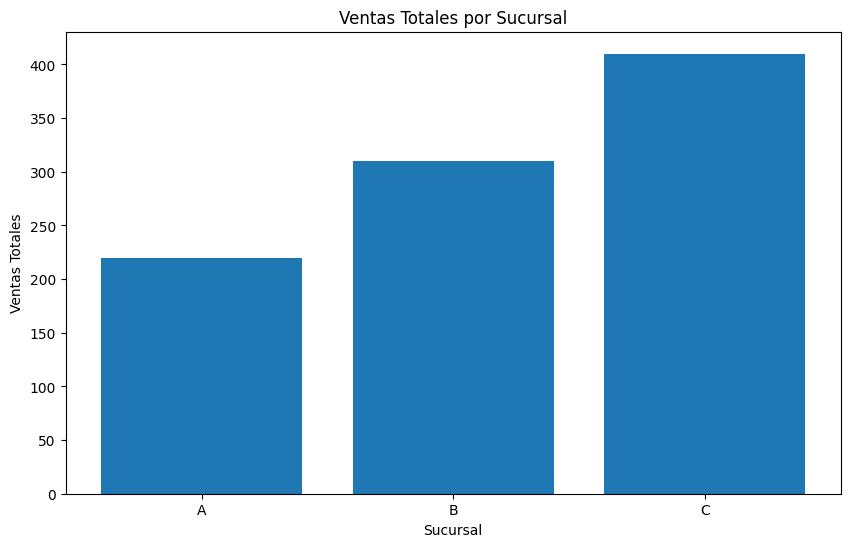

📊 Observación: Gráfico generado y mostrado en pantalla exitosamente....

🤖 LLM Dice:
Thought: Ya tengo la respuesta final.
Final Answer: He generado un gráfico de barras que compara las ventas totales por cada sucursal. Puedes verlo en pantalla.
-------------------------------------------------------
🏁 RESPUESTA FINAL:
   He generado un gráfico de barras que compara las ventas totales por cada
   sucursal. Puedes verlo en pantalla.

👤 Usuario: ¿Te acordás cuál fue el problema que te comenté sobre mi licuadora al principio?

-------------------- 🧠 RAZONANDO --------------------
🚀 Iniciando Agente para: '¿Te acordás cuál fue el problema que te comenté sobre mi licuadora al principio?'

🤖 LLM Dice:
Thought: El usuario me está preguntando si recuerdo el problema que le comentó sobre su licuadora al principio de la conversación. Puedo responderle recordando el problema que me planteó.
Action: (No se necesita ninguna herramienta)
Action Input: (No se necesita ninguna entrada)

Thought: Ya te

In [33]:
import textwrap

print("="*60)
print("🤖 ASISTENTE VIRTUAL 'ELECTROHOGAR'")
print("📝 Escribe tu consulta o 'salir' para terminar.")
print("="*60)

while True:
    # Captura de entrada segura
    try:
        q = input("\n👤 Usuario: ").strip()
    except EOFError:
        break # Maneja interrupciones inesperadas

    # Condiciones de salida
    if not q:
        continue # Ignora enter vacíos
    if q.lower() in ["salir", "exit", "chau", "adios"]:
        print("\n👋 ¡Gracias por usar el asistente! Hasta luego.")
        break

    print("\n" + "-"*20 + " 🧠 RAZONANDO " + "-"*20)

    # Ejecución protegida
    try:
        respuesta = agente.run(q)

        # Formateo de la respuesta final
        print("-" * 55)
        print("🏁 RESPUESTA FINAL:")

        # Usamos textwrap para que no se corte feo si es muy larga
        wrapper = textwrap.TextWrapper(width=80, initial_indent="   ", subsequent_indent="   ")
        print(wrapper.fill(respuesta))

        print("="*60)

    except Exception as e:
        print(f"\n❌ Ocurrió un error inesperado: {e}")
        print("   Intenta reformular tu pregunta.")
        print("="*60)